In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

In [ ]:
# Download training data from open datasets.

# Split data into training and test sets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

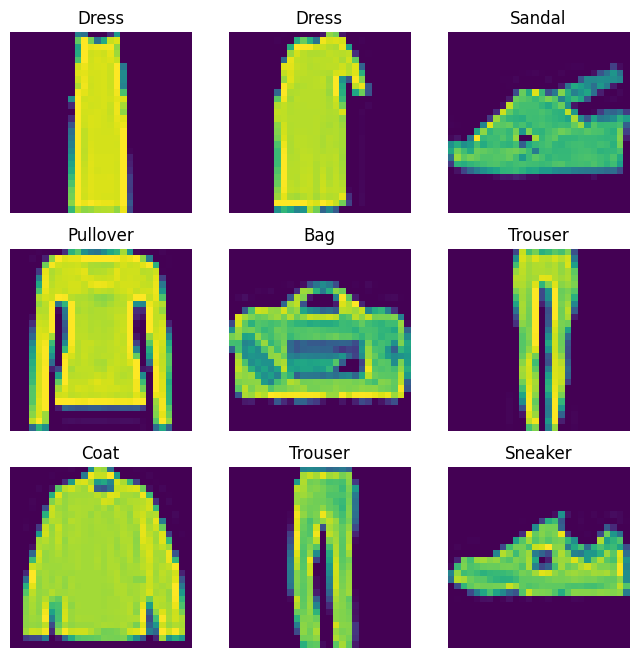

In [5]:
# Print some images from the dataset
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())

In [90]:
# Data Loaders for Batching and Shuffling
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [91]:
# Logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        predictions = self.linear(x)
        return predictions

In [92]:
# Set device and model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

input_size = 28 * 28
num_classes = 10
model = LogisticRegression(input_size=input_size, num_classes=num_classes).to(device)

Using cpu device


In [93]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [94]:
# Train and Test functions for the model
def train(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)
    model.train()

    avg_loss = 0
    avg_pred = 0

    for batch, (X, y) in enumerate(dataloader):
        correct = 0

        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Save loss and predictions
        avg_loss += loss.item()

        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        avg_pred += correct

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss /= size
    avg_pred /= size

    return avg_loss, avg_pred

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [95]:
# Train the model
epochs = 20
loss = []
pred = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    loss_, pred_ = train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    loss.append(loss_)
    pred.append(pred_)

Epoch 1
-------------------------------
loss: 2.324674  [    0/60000]
loss: 2.128165  [ 6400/60000]
loss: 1.894996  [12800/60000]
loss: 1.794496  [19200/60000]
loss: 1.660902  [25600/60000]
loss: 1.593994  [32000/60000]
loss: 1.569682  [38400/60000]
loss: 1.421165  [44800/60000]
loss: 1.421805  [51200/60000]
loss: 1.361839  [57600/60000]
Test Error: 
 Accuracy: 65.0%, Avg loss: 0.021271 

Epoch 2
-------------------------------
loss: 1.353969  [    0/60000]
loss: 1.350234  [ 6400/60000]
loss: 1.282125  [12800/60000]
loss: 1.293524  [19200/60000]
loss: 1.162881  [25600/60000]
loss: 1.082872  [32000/60000]
loss: 1.072201  [38400/60000]
loss: 1.146194  [44800/60000]
loss: 1.071617  [51200/60000]
loss: 1.094475  [57600/60000]
Test Error: 
 Accuracy: 67.4%, Avg loss: 0.017255 

Epoch 3
-------------------------------
loss: 1.092281  [    0/60000]
loss: 1.041191  [ 6400/60000]
loss: 1.074498  [12800/60000]
loss: 0.924692  [19200/60000]
loss: 0.975547  [25600/60000]
loss: 1.190637  [32000/600

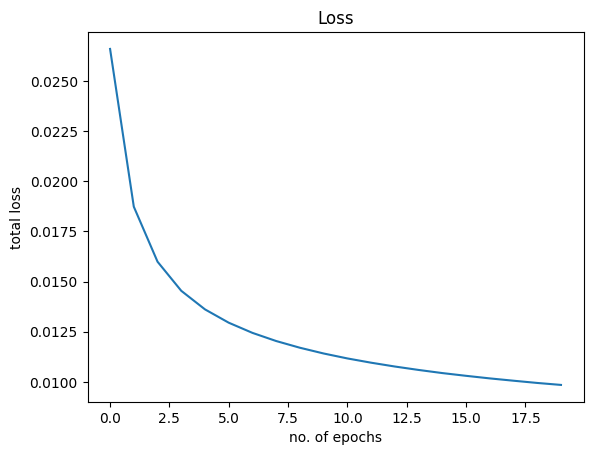

In [96]:
plt.plot(loss)
plt.xlabel("no. of epochs")
plt.ylabel("total loss")
plt.title("Loss")
plt.show()

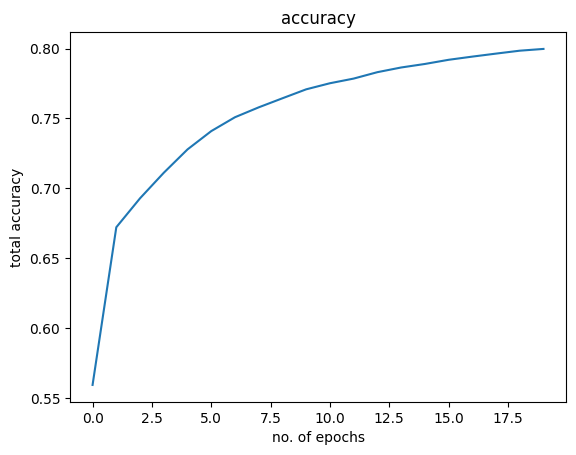

In [98]:
plt.plot(pred)
plt.xlabel("no. of epochs")
plt.ylabel("total accuracy")
plt.title("accuracy")
plt.show()

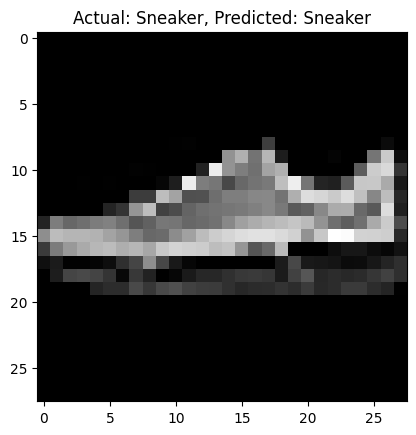

In [114]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Eval the model and print images with predictions
model.eval()
with torch.no_grad():
    X, y = test_data[9][0], test_data[9][1]
    pred = model(X)
    _, predicted = torch.max(pred, 1)

    plt.imshow(X.cpu().numpy().squeeze(), cmap="gray")
    plt.title(f"Actual: {classes[y]}, Predicted: {classes[predicted]}")
    plt.show()
    

#### Conclusion

I understood how pytorch library is meant to work and how easy is to create a neural network.

**Steps done in this notebook:**

1. Load data and split in train, test
2. Create dataloaders
3. Initialize the model
4. Initialize the optimizer and the loss function
5. Create train and test functions for the model
6. Train the model
7. Test the model
8. Enjoy the model
